In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

In [193]:
torch.manual_seed(42)
np.random.seed(42)
num_samples = 100
input_dim = 10
output_dim = 1

X = torch.sin(torch.randn(num_samples, input_dim))
noise = torch.randn(num_samples, output_dim) * 0.1
weights_true = torch.randn(input_dim, output_dim)
y = (torch.matmul(X, weights_true) + noise).reshape(100)

def kernel_function(x, xtag):
    trig_element = np.pi - torch.arccos(x.t() @ (xtag) / (torch.norm(x).item() * torch.norm(xtag)))
    return (x.t() @ (xtag)/(2*np.pi) * trig_element)

H = torch.empty(100, 100)
for i in range(100):
    for j in range(100):
        value = kernel_function(X[i], X[j])
        H[i,j] = value if not math.isnan(value) else 0

In [194]:
class ReLUNN(nn.Module):
    def __init__(self, num_hidden_layers, n,
                 mean=0, std=1, input_dim=input_dim, output_dim=output_dim):
        super(ReLUNN, self).__init__()
        self.n = n
        self.model = nn.Sequential(nn.Linear(input_dim, self.n, bias=False), nn.ReLU())
        for l in range(num_hidden_layers-1): # Depth
            self.model.add_module(f"linear{l}", nn.Linear(self.n, self.n, bias=False))
            self.model.add_module(f"relu{l}", nn.ReLU())
        self.output_weights = 2*torch.bernoulli(0.5*torch.ones(self.n))-1
        self._initialize_weights_normal(mean, std)

    def forward(self, x):
        return self.output_weights @ self.model(x).t() / np.sqrt(self.n)

    def _initialize_weights_normal(self, mean, std):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean, std)

In [196]:
lr_nn = 0.001
lr_dyn = 0.00001
num_iterations = 2000
n = max(input_dim, output_dim)
hidden_widths = [n ** i for i in range(2, 5)]
distances = [[0 for i in range(num_iterations)] for k in range(len(hidden_widths))]
dyn_loss = [[0 for i in range(num_iterations)] for k in range(len(hidden_widths))]
nn_loss = [[0 for i in range(num_iterations)] for k in range(len(hidden_widths))]

torch.manual_seed(42)
for k, hidden_width in enumerate(hidden_widths):
    model = ReLUNN(1, hidden_width)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr_nn)
    
    u_dyn_old = model(X).detach()
    for i in range(num_iterations):
        # Compute loss
        predictions = model(X)
        loss = criterion(y, predictions)

        # Backprop. step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        u_nn = model(X).detach()
        u_dyn_new = u_dyn_old - lr_dyn * torch.matmul(H, u_dyn_old - y)
        u_dyn_old = u_dyn_new
        distances[k][i] = torch.norm(torch.sub(u_nn, u_dyn_new))
        dyn_loss[k][i] = torch.mean((u_dyn_new-y)**2)
        nn_loss[k][i] = torch.mean((u_nn-y)**2)
        

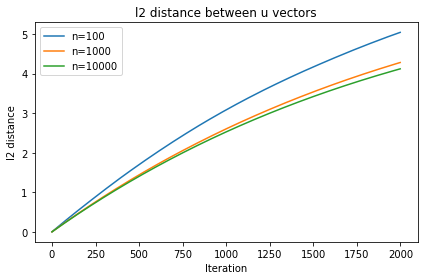

In [197]:
# Plotting the results
plt.figure()

for k, hidden_width in enumerate(hidden_widths):
    plt.subplot(1, 1, 1)
    plt.plot(range(0, num_iterations), distances[k], label=f'n={hidden_width}')
    plt.xlabel('Iteration')
    plt.ylabel('l2 distance')
    plt.title('l2 distance between u vectors')
    plt.legend()

plt.tight_layout()
plt.show()

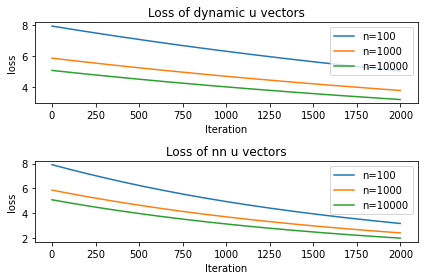

In [198]:
# Plotting the results
plt.figure()

for k, hidden_width in enumerate(hidden_widths):
    plt.subplot(2, 1, 1)
    plt.plot(range(0, num_iterations), dyn_loss[k], label=f'n={hidden_width}')
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.title('Loss of dynamic u vectors')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(0, num_iterations), nn_loss[k], label=f'n={hidden_width}')
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.title('Loss of nn u vectors')
    plt.legend()

plt.tight_layout()
plt.show()